In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Final_Model/stylegan2-swapper'

/content/drive/MyDrive/Final_Model/stylegan2-swapper


In [ ]:
import imageio
import requests
import bz2
import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import dlib
from pix2pixHD.data.base_dataset import __scale_width
from pix2pixHD.models.networks import define_G
import pix2pixHD.util.util as util
from aligner import align_face, get_landmark

from google.colab import output
from IPython.display import HTML, display
import base64


import matplotlib.pyplot as plt
%matplotlib inline

import sys

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
# Add the directory to the system path
sys.path.append('/content/drive/MyDrive/Final_Model/Uploaded Image')

from FIT3162_model_set_up import setup_upload_ui as upload_ui
from FIT3162_model_set_up import setup_jscode as upload_js
from FIT3162_model_set_up import process_image_data as process_image

In [ ]:
# bz2 file unpack function
def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path

#file download function
def download(url, file_name):
    with open(file_name, "wb") as file:
        response = requests.get(url)
        file.write(response.content)

In [ ]:
# Define the paths
shape_model_drive_path = '/content/drive/MyDrive/Final_Model/shape_predictor_68_face_landmarks.dat.bz2'
shape_model_extracted_path = '/content/drive/MyDrive/Final_Model/shape_predictor_68_face_landmarks.dat'

# Extract the contents in Google Drive
with open(shape_model_extracted_path, 'wb') as new_file, bz2.BZ2File(shape_model_drive_path, 'rb') as file:
    shutil.copyfileobj(file, new_file)

# Load the model
shape_predictor = dlib.shape_predictor(shape_model_extracted_path)

In [ ]:
config_G = {
    'input_nc': 3,
    'output_nc': 3,
    'ngf': 64,
    'netG': 'global',
    'n_downsample_global': 4,
    'n_blocks_global': 9,
    'n_local_enhancers': 1,
    'norm': 'instance',
}

to_male_weights = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/to_male_net_G.pth'
to_male_model = define_G(**config_G)
pretrained_dict = torch.load(to_male_weights)
to_male_model.load_state_dict(pretrained_dict)
to_male_model.cuda();

to_female_weights = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/to_female_net_G.pth'
to_female_model = define_G(**config_G)
pretrained_dict = torch.load(to_female_weights)
to_female_model.load_state_dict(pretrained_dict)
to_female_model.cuda();

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

In [ ]:
def get_eval_transform(loadSize=512):
    transform_list = []
    transform_list.append(transforms.Lambda(lambda img: __scale_width(img,
                                                                      loadSize,
                                                                      Image.BICUBIC)))
    transform_list += [transforms.ToTensor()]
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

transform = get_eval_transform()

In [ ]:
# using torch
def find_cosine_similarity(input_tensor, generated_image):
  # Convert the NumPy array to a PyTorch tensor
  output_tensor = torch.from_numpy(generated_image).permute(2, 0, 1).unsqueeze(0).float()
  # Flatten the tensors to 1D vectors (if needed)
  tensor1_flat = input_tensor.view(1, -1)
  tensor2_flat = output_tensor.view(1, -1)

  # define a method to measure cosine similarity
  cos = torch.nn.CosineSimilarity(dim=1)
  output = cos(tensor1_flat, tensor2_flat)

  # display the output tensor
  return output

def get_similarity_percentage_using_torch(input_tensor, generated_image):
  cos = find_cosine_similarity(input_tensor, generated_image)
  percentage= ((cos.item() + 1) / 2) * 100
  return percentage

# Find Cosine Similarity of Female Image

000022.jpg: Number of faces detected: 1


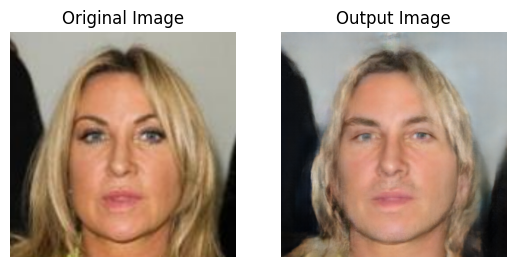

Cosine Similarity of Female Image: tensor([0.3261])
Cosine Similarity % of Female Image: 66.30639135837555


In [ ]:
female_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female/000022.jpg'

aligned_img = align_face(female_input_image, shape_predictor)

if len(aligned_img) > 0:
  img = transform(aligned_img[0]).unsqueeze(0)
  with torch.no_grad():
    out = to_male_model(img.cuda())

  out = util.tensor2im(out.data[0])

  # Visualize the original image
  plt.subplot(1, 2, 1)
  plt.imshow(aligned_img[0])
  plt.title('Original Image')
  plt.axis('off')

  # Visualize the output image
  plt.subplot(1, 2, 2)
  plt.imshow(out)
  plt.title('Output Image')
  plt.axis('off')

  # Show the images
  plt.show()
  print("Cosine Similarity of Female Image: " + str(find_cosine_similarity(img, out)))
  print("Cosine Similarity % of Female Image: "+ str(get_similarity_percentage_using_torch(img, out)))

else:
  print("No face found")

# Find Cosine Similarity of Male Image

000129.jpg: Number of faces detected: 1


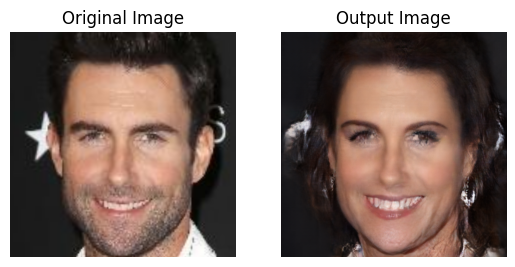

Cosine Similarity of Female Image: tensor([0.0573])
Cosine Similarity % of Female Image: 52.866436168551445


In [ ]:
male_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Male/000129.jpg'

aligned_img = align_face(male_input_image, shape_predictor)

if len(aligned_img) > 0:
  img = transform(aligned_img[0]).unsqueeze(0)
  with torch.no_grad():
    out = to_female_model(img.cuda())

  out = util.tensor2im(out.data[0])

  # Visualize the original image
  plt.subplot(1, 2, 1)
  plt.imshow(aligned_img[0])
  plt.title('Original Image')
  plt.axis('off')

  # Visualize the output image
  plt.subplot(1, 2, 2)
  plt.imshow(out)
  plt.title('Output Image')
  plt.axis('off')

  # Show the images
  plt.show()
  print("Cosine Similarity of Female Image: " + str(find_cosine_similarity(img, out)))
  print("Cosine Similarity % of Female Image: "+ str(get_similarity_percentage_using_torch(img, out)))

else:
  print("No face found")

# Average Cosine Similarity Percentage on Male Dataset

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import time


to_female_model.eval()

# Path to your dataset folder in Google Drive
dataset_folder = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Male'

similarity_percentages_male = []

# Start the timer
start_time = time.time()
# Iterate through all files in the folder
for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Check if it's an image file
      # join path
      img_url = os.path.join(dataset_folder, filename)
      # align image
      aligned_img = align_face(img_url, shape_predictor)
      if len(aligned_img) > 0:
        img = transform(aligned_img[0]).unsqueeze(0)
        with torch.no_grad():
          out = to_female_model(img.cuda())
        out = util.tensor2im(out.data[0])
        percentage = get_similarity_percentage_using_torch(img, out)
        similarity_percentages_male.append(percentage)
      # else:
      #   print("No face found: " + str(filename))
# Stop the timer
end_time = time.time()

# Calculate the time taken
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = int(elapsed_time % 60)

average = sum(similarity_percentages_male) / len(similarity_percentages_male)
print(f"Average Similarity Percentage: {average:.2f}%")
print(f"Time taken: {elapsed_minutes} minutes and {elapsed_seconds} seconds of {len(similarity_percentages_male)} files")



001193.jpg: Number of faces detected: 1
001196.jpg: Number of faces detected: 1
001197.jpg: Number of faces detected: 1
001199.jpg: Number of faces detected: 1
001201.jpg: Number of faces detected: 1
001204.jpg: Number of faces detected: 1
001206.jpg: Number of faces detected: 1
001207.jpg: Number of faces detected: 1
001208.jpg: Number of faces detected: 1
001209.jpg: Number of faces detected: 1
001210.jpg: Number of faces detected: 1
001213.jpg: Number of faces detected: 1
001215.jpg: Number of faces detected: 1
001216.jpg: Number of faces detected: 1
001217.jpg: Number of faces detected: 1
001220.jpg: Number of faces detected: 1
001222.jpg: Number of faces detected: 1
001224.jpg: Number of faces detected: 1
001225.jpg: Number of faces detected: 2
001228.jpg: Number of faces detected: 1
001229.jpg: Number of faces detected: 1
001230.jpg: Number of faces detected: 1
001231.jpg: Number of faces detected: 1
001237.jpg: Number of faces detected: 1
001239.jpg: Number of faces detected: 1


In [ ]:
# Calculate the time taken
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = int(elapsed_time % 60)

average = sum(similarity_percentages_male) / len(similarity_percentages_male)
print(f"Average Similarity Percentage: {average:.2f}%")
print(f"Time taken: {elapsed_minutes} minutes and {elapsed_seconds} seconds of {len(similarity_percentages_male)} files")


Average Similarity Percentage: 61.47%
Time taken: 34 minutes and 48 seconds of 1441 files


# Average Cosine Similarity Percentage on Female Dataset

In [ ]:
dataset_folder = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female'


similarity_percentages_female = []
to_female_model.eval()

# Start the timer
start_time = time.time()
# Iterate through all files in the folder
for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Check if it's an image file
      # join path
      img_url = os.path.join(dataset_folder, filename)
      # align image
      aligned_img = align_face(img_url, shape_predictor)
      if len(aligned_img) > 0:
        img = transform(aligned_img[0]).unsqueeze(0)
        with torch.no_grad():
          out = to_female_model(img.cuda())
        out = util.tensor2im(out.data[0])
        percentage = get_similarity_percentage_using_torch(img, out)
        similarity_percentages_female.append(percentage)
      # else:
      #   print("No face found: " + str(filename))
# Stop the timer
end_time = time.time()


000882.jpg: Number of faces detected: 0
000883.jpg: Number of faces detected: 1
000884.jpg: Number of faces detected: 1
000887.jpg: Number of faces detected: 1
000890.jpg: Number of faces detected: 1
000891.jpg: Number of faces detected: 1
000893.jpg: Number of faces detected: 1
000894.jpg: Number of faces detected: 1
000895.jpg: Number of faces detected: 1
000896.jpg: Number of faces detected: 1
000897.jpg: Number of faces detected: 1
000899.jpg: Number of faces detected: 1
000900.jpg: Number of faces detected: 1
000901.jpg: Number of faces detected: 1
000909.jpg: Number of faces detected: 1
000910.jpg: Number of faces detected: 1
000912.jpg: Number of faces detected: 1
000914.jpg: Number of faces detected: 1
000916.jpg: Number of faces detected: 1
000917.jpg: Number of faces detected: 1
000918.jpg: Number of faces detected: 1
000919.jpg: Number of faces detected: 1
000920.jpg: Number of faces detected: 1
000921.jpg: Number of faces detected: 1
000922.jpg: Number of faces detected: 1


In [ ]:
# Calculate the time taken
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = int(elapsed_time % 60)

average = sum(similarity_percentages_female) / len(similarity_percentages_female)
print(f"Average Similarity Percentage: {average:.2f}%")
print(f"Time taken: {elapsed_minutes} minutes and {elapsed_seconds} seconds of {len(similarity_percentages_female)} files")

Average Similarity Percentage: 63.42%
Time taken: 35 minutes and 36 seconds of 1458 files


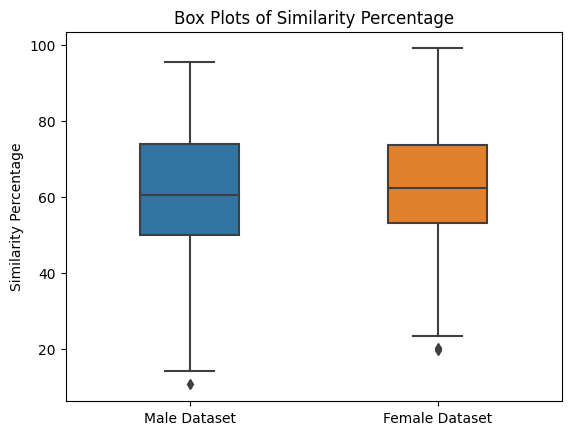

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Pad the smaller list with NaNs to make them of equal length
max_length = max(len(similarity_percentages_male), len(similarity_percentages_female))
similarity_percentages_male += [np.nan] * (max_length - len(similarity_percentages_male))
similarity_percentages_female += [np.nan] * (max_length - len(similarity_percentages_female))


# Create a DataFrame for Seaborn
data = pd.DataFrame({'Male Dataset': similarity_percentages_male, 'Female Dataset': similarity_percentages_female})

# Plotting side by side boxplots
sns.boxplot(data=data, width=0.4)
plt.ylabel('Similarity Percentage')
plt.title('Box Plots of Similarity Percentage')
plt.show()

# Average Cosine Similarity of a Mixed Dataset

In [ ]:
# Load trained weight (base model = Resnet18)
save_path = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/gender_classification_dataset/face_gender_classification_trained_weights_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

def get_predicted_gender(img_url):

  model.eval()
  # Load the image using PIL
  input_image = Image.open(img_url)

  # Define the preprocessing steps
  preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
  ])

  # Apply the preprocessing to your input image
  input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

  # Move the input tensor to the appropriate device (GPU if available)
  input_tensor = input_tensor.to(device)

  # Pass the preprocessed image through the model
  with torch.no_grad():
    output = model(input_tensor)
  # Get the predicted class
  _, predicted = torch.max(output, 1)

  class_names = ["Female", "Male"]

  # Map the predicted class index to the class label
  predicted_class = class_names[predicted.item()]
  # print("Predicted class:", predicted_class)
  return predicted_class

In [ ]:
dataset_folder = '/content/drive/MyDrive/Final_Model/MaleFemaleDataset'


similarity_percentages = []
to_female_model.eval()
to_male_model.eval()
gender_model = None
# Start the timer
start_time = time.time()
# Iterate through all files in the folder
for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Check if it's an image file
      # join path
      img_url = os.path.join(dataset_folder, filename)
      # align image
      aligned_img = align_face(img_url, shape_predictor)
      if len(aligned_img) > 0:
        img = transform(aligned_img[0]).unsqueeze(0)

        if get_predicted_gender(img_url) == "Female":
          gender_model = to_male_model
        else:
          gender_model = to_female_model
        with torch.no_grad():
          out = gender_model(img.cuda())
        out = util.tensor2im(out.data[0])
        percentage = get_similarity_percentage_using_torch(img, out)
        similarity_percentages.append(percentage)
      # else:
      #   print("No face found: " + str(filename))
# Stop the timer
end_time = time.time()

000023.jpg: Number of faces detected: 1
000014.jpg: Number of faces detected: 1
000012.jpg: Number of faces detected: 1
000002.jpg: Number of faces detected: 1
000010.jpg: Number of faces detected: 1
000007.jpg: Number of faces detected: 1
000003.jpg: Number of faces detected: 0
000009.jpg: Number of faces detected: 1
000005.jpg: Number of faces detected: 1
000004.jpg: Number of faces detected: 0
000008.jpg: Number of faces detected: 1
000044.jpg: Number of faces detected: 1
000037.jpg: Number of faces detected: 1
000031.jpg: Number of faces detected: 1
000035.jpg: Number of faces detected: 1
000030.jpg: Number of faces detected: 1
000034.jpg: Number of faces detected: 1
000036.jpg: Number of faces detected: 0
000028.jpg: Number of faces detected: 1
000032.jpg: Number of faces detected: 1
000029.jpg: Number of faces detected: 1
000033.jpg: Number of faces detected: 1
000027.jpg: Number of faces detected: 1
000026.jpg: Number of faces detected: 1
000015.jpg: Number of faces detected: 1


In [ ]:
# Calculate the time taken
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = int(elapsed_time % 60)

average = sum(similarity_percentages) / len(similarity_percentages)
print(f"Average Similarity Percentage: {average:.2f}%")
print(f"Time taken: {elapsed_minutes} minutes and {elapsed_seconds} seconds of {len(similarity_percentages)} files")

Average Similarity Percentage: 61.34%
Time taken: 33 minutes and 32 seconds of 933 files


In [ ]:
# import unittest

# class TestGenderPrediction(unittest.TestCase):
#     def test_input_male_image(self):
#         # Test case 1: Input Male Image
#         male_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Male/000129.jpg'
#         gender = get_predicted_gender(male_input_image)
#         self.assertEqual(gender, 'Male')

#     def test_input_female_image(self):
#         # Test case 2: Input Female Image
#         female_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female/000028.jpg'
#         gender = get_predicted_gender(female_input_image)
#         self.assertEqual(gender, 'Female')

# if __name__ == '__main__':
#     import unittest
#     unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [ ]:
import unittest

class TestAlignFace(unittest.TestCase):
    def test_align_face_with_faces(self):
        # Test case 1: Input Male Image
        male_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Male/000129.jpg'
        aligned_img = align_face(male_input_image, shape_predictor)
        self.assertNotEqual(len(aligned_img), 0)
        print("Test 'test_input_male_image' executed")

    # def test_input_female_image(self):
    #     # Test case 2: Input Female Image
    #     female_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female/000028.jpg'
    #     gender = get_predicted_gender(female_input_image)
    #     self.assertEqual(gender, 'Female')

if __name__ == '__main__':
    import unittest
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

000129.jpg: Number of faces detected: 1


.
----------------------------------------------------------------------
Ran 1 test in 10.238s

OK


Test 'test_input_male_image' executed


In [ ]:
%run Tests/TestAlignFace.py

000917.jpg: Number of faces detected: 1


.

000980.jpg: Number of faces detected: 1


.

000917.jpg: Number of faces detected: 1


.

000027.jpg: Number of faces detected: 1


.E

000129.jpg: Number of faces detected: 1


.
ERROR: test_female_with_glasses (__main__.TestAlignFace)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/drive/MyDrive/Final_Model/stylegan2-swapper/Tests/TestAlignFace.py", line 34, in test_female_with_glasses
    aligned_img = align_face(female_input_image, shape_predictor)
  File "/content/drive/MyDrive/Final_Model/stylegan2-swapper/aligner.py", line 50, in align_face
    lms = get_landmark(filepath,predictor)
  File "/content/drive/MyDrive/Final_Model/stylegan2-swapper/aligner.py", line 33, in get_landmark
    img = dlib.load_rgb_image(filepath)
RuntimeError: Unable to open file: /content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female/002134.jpg

----------------------------------------------------------------------
Ran 6 tests in 7.488s

FAILED (errors=1)


## Input image with 1 face

In [ ]:
female_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female/000022.jpg'

landmarks = get_landmark(female_input_image, shape_predictor)
if len(landmarks) == 1:
  print("Test Pass")

000022.jpg: Number of faces detected: 1
Test Pass


## Input with No face image

In [ ]:
dataset_folder = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Female/000882.jpg'

landmarks = get_landmark(female_input_image, shape_predictor)
if len(landmarks) == 0:
  print("Test Pass")

000022.jpg: Number of faces detected: 1


## Valid input image for Face Alignment

In [ ]:
female_input_image = '/content/drive/MyDrive/Final_Model/CelebA_Attribute_Dataset/Male/000129.jpg'
landmarks = align_face(female_input_image, shape_predictor)
if len(landmarks) == 1:
  print("Test Pass")

000129.jpg: Number of faces detected: 1
Test Pass


## Invalid Input image for face alignment

In [ ]:
female_input_image = '/content/drive/MyDrive/Final_Mod2el/CelebA_Attribute_Dataset/Male/000129.jpg'
landmarks = align_face(female_input_image, shape_predictor)
if len(landmarks) == 1:
  print("Test Pass")

RuntimeError: Unable to open file: /content/drive/MyDrive/Final_Mod2el/CelebA_Attribute_Dataset/Male/000129.jpg

In [ ]:
%run Tests/WhiteBoxTestForGenderPrection.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
.......
----------------------------------------------------------------------
Ran 7 tests in 0.175s

OK
